<h1><center>Sam Armstrong CS548 Project</center></h1>
<h1><center>Variational Autoencoder with Classifier Dataset 1 (UCI)</center></h1>

## Import Libraries

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader

#For Clustering
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d 

#For Training/Testing Split
from sklearn.model_selection import train_test_split

## Check for GPU

In [2]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if cuda else "cpu")

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'


## Set Seeds

In [3]:
seed = 0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)

## Load RNA-Seq Data

In [4]:
seq_data = pd.read_csv("tumor_data/data.csv")
seq_data.rename(columns={'Unnamed: 0':'sample'}, inplace=True)

## Load Tumor Type/Class Data

In [5]:
labels = pd.read_csv("tumor_data/labels.csv")
labels.rename(columns={'Unnamed: 0':'sample'}, inplace=True)

## Join RNA-Seq and Tumor Type/Class Data

In [6]:
tumor_data = seq_data.set_index('sample').join(labels.set_index('sample')).to_numpy()

## Training/Testing Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(tumor_data[:, :-1], tumor_data[:, -1], test_size=0.20, random_state=seed, stratify=tumor_data[:, -1])

In [8]:
tumor_train_data = np.concatenate((X_train, y_train.reshape(y_train.shape[0], 1)), axis=1)

In [9]:
tumor_test_data = np.concatenate((X_test, y_test.reshape(y_test.shape[0], 1)), axis=1)

## Custom Pytorch Dataset for Cancer Data

In [10]:
class CancerDataset(Dataset):
    
    def __init__(self, data, transform=None):
        'Initialization'
        self.labels = data[:, -1]
        self.lookup_table, self.labels = np.unique(data[:, -1], return_inverse=True)
        self.genes = data[:, :-1]
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = torch.from_numpy(self.genes[index, : ].astype(np.float)).float()
        y = torch.from_numpy(np.unique(self.labels[index]).astype(int))

        return X, y

## Encoder Class

In [11]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

## Decoder Class

In [12]:
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

## Classifier Class

In [13]:
class Classifier(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Classifier, self).__init__()
        
        self.linears = torch.nn.ModuleList([torch.nn.Linear(D_in, H[0])])
        
        for i in range(1,len(H)):
            self.linears.append(torch.nn.Linear(H[i-1], H[i]))
            
        self.linears.append(torch.nn.Linear(H[-1], D_out))
  
    def forward(self, x):
        for h in self.linears:
            x = h(x)
       
        return F.softmax(x, dim=1)

## Variational Autoencoder Class with Classifier

In [14]:
class VAE(torch.nn.Module):

    def __init__(self, encoder, decoder, classifier, latent_dim):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier
        self._enc_mu = torch.nn.Linear(self.encoder.linear2.out_features, latent_dim)
        self._enc_log_sigma = torch.nn.Linear(self.encoder.linear2.out_features, latent_dim)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu.to(device)
        self.z_sigma = sigma.to(device)

        return mu + sigma * Variable(std_z, requires_grad=False).to(device)  
    
    
    def forwardEncoder(self, state):
        h_enc = self.encoder(state)
        return self._sample_latent(h_enc)
    
    def forwardAutoEncoder(self, state):
        z = self.forwardEncoder(state)
        return self.decoder(z)
    
    def forwardClassifier(self, state):
        z = self.forwardEncoder(state)
        return self.classifier(z)
    
    def saveModel(self, fileName="vaeModel"):
        torch.save(self.state_dict(), fileName)
        print("Model Saved Successfully")
        
    def loadModel(self, fileName="vaeModel", map_location=None):
        if(map_location == None):
            self.load_state_dict(torch.load(fileName))
        else:
            self.load_state_dict(torch.load(fileName, map_location=map_location))
        self.eval()

## Custom Loss Method (Kullback–Leibler Loss)

In [15]:
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

## Train Classifier (Encoder + Classifier)

In [16]:
def trainClassifier(modelName, loadModel=False, saveModel=True, input_dim = 20531, latent_dim = 10, encoding_layer = 100, classifier_layers = [20, 20, 20], n_classes = 5, batch_size = 32, epochs = 10, verbose = True):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    encoder = Encoder(input_dim, encoding_layer, encoding_layer)
    decoder = Decoder(latent_dim, encoding_layer, input_dim)
    classifier = Classifier(latent_dim, classifier_layers, n_classes)

    vae = VAE(encoder, decoder, classifier, latent_dim)
    
    if loadModel:
        vae.loadModel(modelName)
        
    if cuda:
        vae.cuda()

    train_loader = torch.utils.data.DataLoader( CancerDataset(tumor_train_data), batch_size=batch_size, shuffle=True, drop_last=True)

    if verbose:
        print('Number of samples: ', len(tumor_data))

    criterion = torch.nn.CrossEntropyLoss()

    optimizer = optim.Adam(vae.parameters(), lr=0.0001)

    l = None
    for epoch in range(epochs):
        for i, data in enumerate(train_loader, 0):
            inputs, classes = data
            inputs, classes = Variable(inputs.resize_(batch_size, input_dim)).to(device), Variable(classes).flatten().long().to(device)
            predictions = vae.forwardClassifier(inputs.float())
            optimizer.zero_grad()
            ll = latent_loss(vae.z_mean, vae.z_sigma)
            loss = criterion(predictions, classes) + ll
            loss.backward()
            optimizer.step()
            l = loss.item()
        if verbose:
            print(epoch, l)
        
    if saveModel:
        vae.saveModel(modelName)
        
    return vae

In [17]:
trainClassifier("testModel", saveModel=False, epochs=2)

Number of samples:  801
0 2.0439963340759277
1 1.6577918529510498


VAE(
  (encoder): Encoder(
    (linear1): Linear(in_features=20531, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=10, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=20531, bias=True)
  )
  (classifier): Classifier(
    (linears): ModuleList(
      (0): Linear(in_features=10, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Linear(in_features=20, out_features=5, bias=True)
    )
  )
  (_enc_mu): Linear(in_features=100, out_features=10, bias=True)
  (_enc_log_sigma): Linear(in_features=100, out_features=10, bias=True)
)

## Get Classifier Percentage Correct on Train Data

In [18]:
def getClassifierAccuracy(model, input_dim = 20531, batch_size = 32):
    correct = 0
    total = 0
    train_loader = torch.utils.data.DataLoader( CancerDataset(tumor_test_data), batch_size=batch_size)
    
    for i, data in enumerate(train_loader, 0):
        inputs, classes = data
        inputs, classes = Variable(inputs.resize_(batch_size, input_dim)).to(device), Variable(classes).flatten().long().to(device)
        predictions = model.forwardClassifier(inputs.float())
        _, predicted = torch.max(predictions.data, 1)
        total += classes.size(0)
        correct += (predicted == classes).sum().item()
    
    return (correct / total)

In [19]:
model = trainClassifier("testModel", saveModel=False, epochs=2)
getClassifierAccuracy(model)

Number of samples:  801
0 2.0439963340759277
1 1.6577918529510498


0.2857142857142857

## Optimal Model Found and Saved as maxModel1
Model has latent dimension size 21, classifier architecture of [60, 60, 60, 60], and 100% correct on testing data.

## Create Clustering Data

In [20]:
encoder = Encoder(20531, 100, 100)
decoder = Decoder(21, 100, 20531)
classifier = Classifier(21, [60, 60, 60, 60], 5)

vae = VAE(encoder, decoder, classifier, 21)
vae.loadModel("maxModel1", map_location=torch.device('cpu'))

In [21]:
cluster_loader = torch.utils.data.DataLoader( CancerDataset(tumor_data), batch_size=1, shuffle=False)

In [22]:
for i, data in enumerate(cluster_loader, 0):
    inputs, classes = data
    inputs, classes = Variable(inputs.resize_(1, 20531)), Variable(classes).flatten().long()
    encoded_vector = vae.forwardEncoder(inputs.float()).detach().numpy()
    
    if(i == 0):
        cluster_data = encoded_vector
        cluster_labels = classes.detach().numpy()
    else:
    
        cluster_data = np.append(cluster_data, encoded_vector, axis=0)
        cluster_labels = np.append(cluster_labels, classes.detach().numpy(), axis=0)

In [23]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [24]:
columns = []
for i in range(21):
    columns.append("col" + str(i))  

In [25]:
cluster_data_pd = pd.DataFrame(data=cluster_data, index=indices, columns=columns)

In [26]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])
columns.append("label")

In [27]:
cluster_pd = pd.concat([cluster_data_pd, cluster_labels_pd], axis=1, sort=False)

## Pairwise Clustering

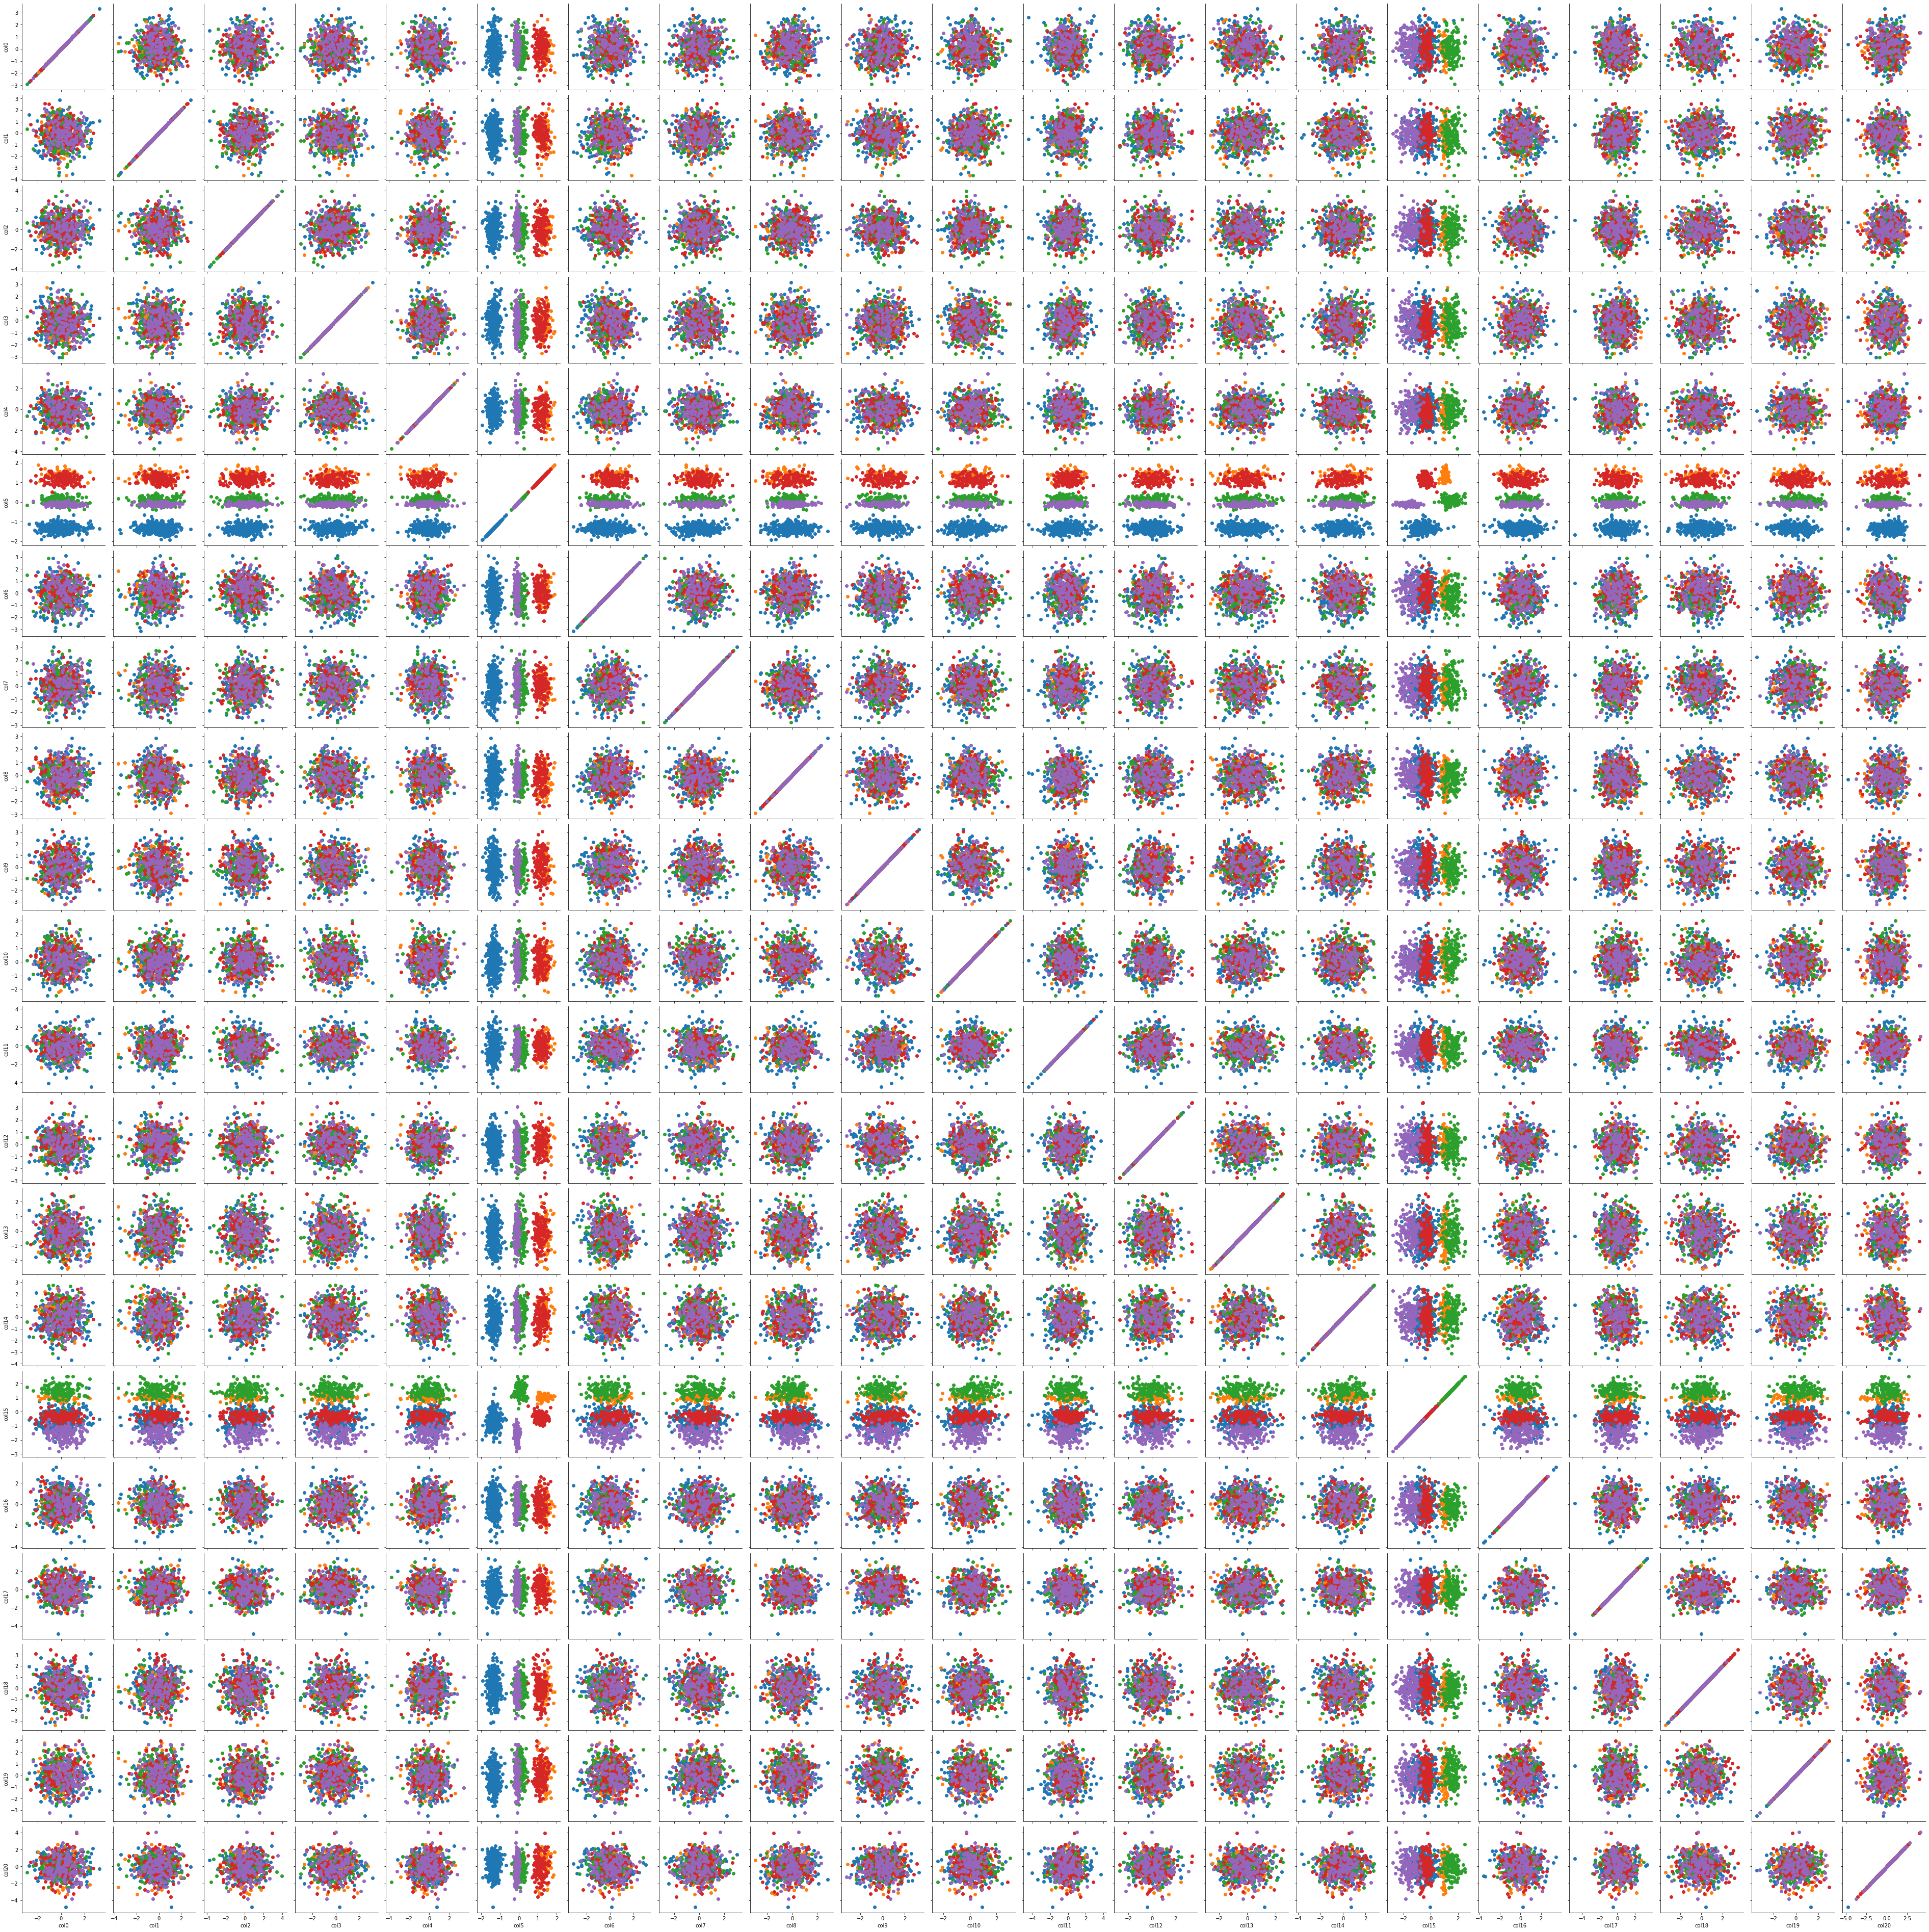

In [29]:
g = sns.PairGrid(cluster_pd, hue = 'label')
g.map(plt.scatter);

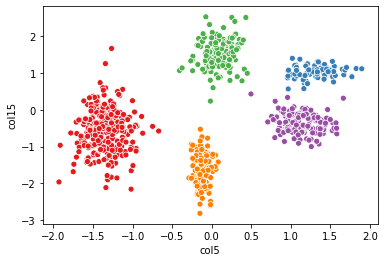

In [30]:
ax = sns.scatterplot(x="col5", y="col15", hue="label", palette="Set1", legend=False,  data=cluster_pd)

## PCA

In [36]:
# %matplotlib notebook

In [37]:
from sklearn.decomposition import PCA

In [38]:
pca2 = PCA(n_components=2)
pca3 = PCA(n_components=3)

In [39]:
pca_dim2 = pca2.fit_transform(cluster_data)
pca_dim3 = pca3.fit_transform(cluster_data)

In [40]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [41]:
pca2_df = pd.DataFrame(data = pca_dim2, index = indices, columns = ['PCA1', 'PCA2'])
pca3_df = pd.DataFrame(data = pca_dim3, index = indices, columns = ['PCA1', 'PCA2', 'PCA3'])

In [42]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [43]:
pca2_df2 = pd.concat([pca2_df, cluster_labels_pd], axis=1, sort=False)
pca3_df2 = pd.concat([pca3_df, cluster_labels_pd], axis=1, sort=False)

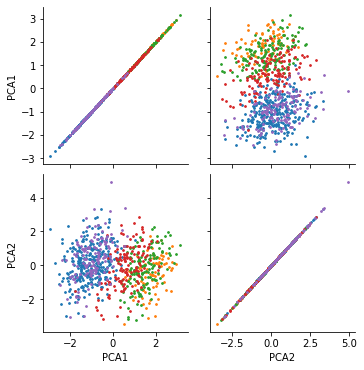

In [44]:
g = sns.PairGrid(pca2_df2, hue = 'label')
g.map(plt.scatter, s=3);

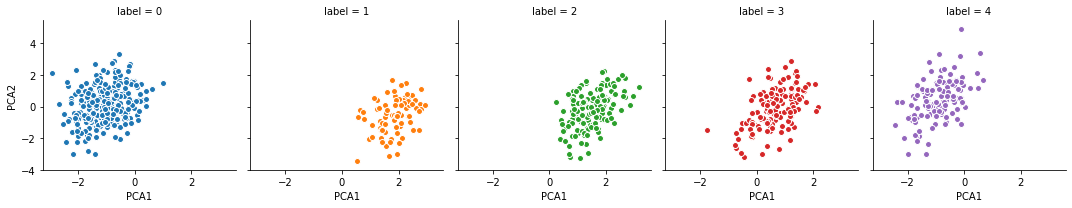

In [45]:
g = sns.FacetGrid(pca2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "PCA1", "PCA2", edgecolor="w"))

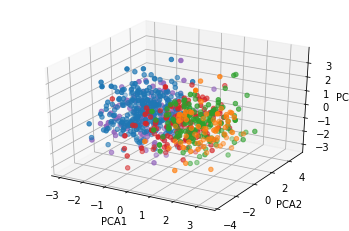

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pca3_df3 = pca3_df2.groupby("label")

for name, group in pca3_df3:
    ax.scatter(group["PCA1"], group["PCA2"], group["PCA3"], marker="o", label=name)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()

## MDS

Multi-dimensional scaling (MDS) : A technique used for analyzing similarity or dissimilarity of data as distances in a geometric spaces. Projects data to a lower dimension such that data points that are close to each other (in terms if Euclidean distance) in the higher dimension are close in the lower dimension as well.

In [47]:
from sklearn.manifold import MDS

In [48]:
mds2 = MDS(n_components=2)
mds3 = MDS(n_components=3)

In [49]:
mds_dim2 = mds2.fit_transform(cluster_data)
mds_dim3 = mds3.fit_transform(cluster_data)

In [50]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [51]:
mds2_df = pd.DataFrame(data = mds_dim2, index = indices, columns = ['MDS1', 'MDS2'])
mds3_df = pd.DataFrame(data = mds_dim3, index = indices, columns = ['MDS1', 'MDS2', 'MDS3'])

In [52]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [53]:
mds2_df2 = pd.concat([mds2_df, cluster_labels_pd], axis=1, sort=False)
mds3_df2 = pd.concat([mds3_df, cluster_labels_pd], axis=1, sort=False)

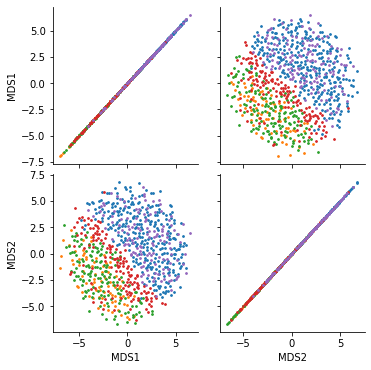

In [54]:
g = sns.PairGrid(mds2_df2, hue = 'label')
g.map(plt.scatter, s=3);

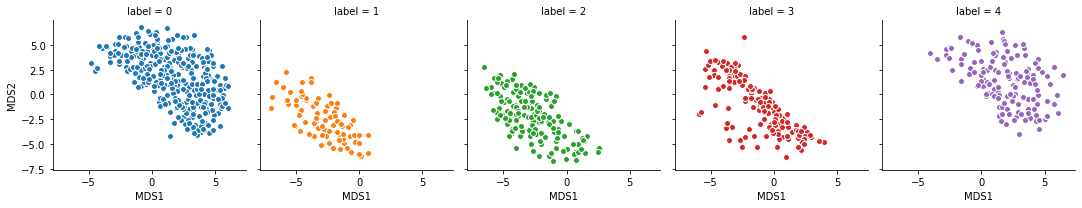

In [55]:
g = sns.FacetGrid(mds2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "MDS1", "MDS2", edgecolor="w"))

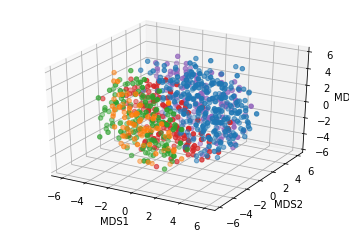

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mds3_df3 = mds3_df2.groupby("label")

for name, group in mds3_df3:
    ax.scatter(group["MDS1"], group["MDS2"], group["MDS3"], marker="o", label=name)

ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')
ax.set_zlabel('MDS3')

plt.show()

## Isomap

Isometric Feature Mapping (Isomap) : Projects data to a lower dimension while preserving the geodesic distance (rather than Euclidean distance as in MDS). Geodesic distance is the shortest distance between two points on a curve.

In [57]:
from sklearn.manifold import Isomap

In [58]:
isomap2 = Isomap(n_components=2)
isomap3 = Isomap(n_components=3)

In [59]:
isomap_dim2 = isomap2.fit_transform(cluster_data)
isomap_dim3 = isomap3.fit_transform(cluster_data)

In [60]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [61]:
isomap2_df = pd.DataFrame(data = isomap_dim2, index = indices, columns = ['ISOMAP1', 'ISOMAP2'])
isomap3_df = pd.DataFrame(data = isomap_dim3, index = indices, columns = ['ISOMAP1', 'ISOMAP2','ISOMAP3'])

In [62]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [63]:
isomap2_df2 = pd.concat([isomap2_df, cluster_labels_pd], axis=1, sort=False)
isomap3_df2 = pd.concat([isomap3_df, cluster_labels_pd], axis=1, sort=False)

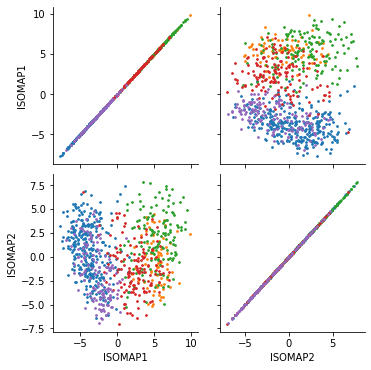

In [64]:
g = sns.PairGrid(isomap2_df2, hue = 'label')
g.map(plt.scatter, s=3);

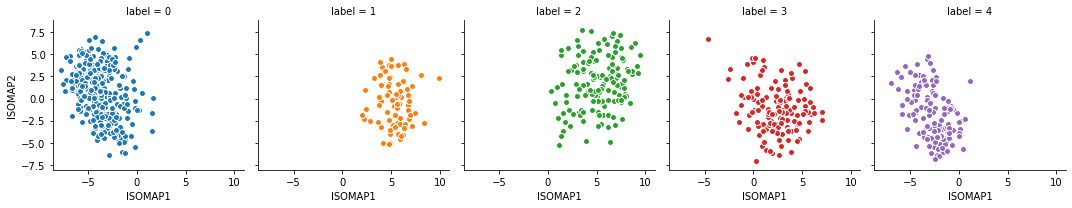

In [65]:
g = sns.FacetGrid(isomap2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "ISOMAP1", "ISOMAP2", edgecolor="w"))

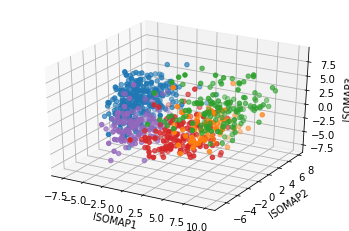

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

isomap3_df3 = isomap3_df2.groupby("label")

for name, group in isomap3_df3:
    ax.scatter(group["ISOMAP1"], group["ISOMAP2"], group["ISOMAP3"], marker="o", label=name)

ax.set_xlabel('ISOMAP1')
ax.set_ylabel('ISOMAP2')
ax.set_zlabel('ISOMAP3')

plt.show()

## LLE

Locally Linear Embedding (LLE): Recovers global non-linear structure from linear fits. Each local patch of the manifold can be written as a linear, weighted sum of its neighbours given enough data.

In [67]:
from sklearn.manifold import LocallyLinearEmbedding

In [68]:
lle2 = LocallyLinearEmbedding(n_components=3)
lle3 = LocallyLinearEmbedding(n_components=4)

In [69]:
lle_dim2 = lle2.fit_transform(cluster_data)
lle_dim3 = lle3.fit_transform(cluster_data)

In [70]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [71]:
lle2_df = pd.DataFrame(data = lle_dim2, index = indices, columns = ['LLE1', 'LLE2', 'LLE3'])
lle3_df = pd.DataFrame(data = lle_dim3, index = indices, columns = ['LLE1', 'LLE2', 'LLE3', 'LLE4'])

In [72]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [73]:
lle2_df2 = pd.concat([lle2_df, cluster_labels_pd], axis=1, sort=False)
lle3_df2 = pd.concat([lle3_df, cluster_labels_pd], axis=1, sort=False)

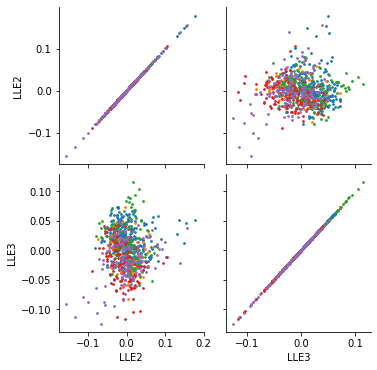

In [74]:
g = sns.PairGrid(lle2_df2[["LLE2", "LLE3", 'label']], hue = 'label')
g.map(plt.scatter, s=3);

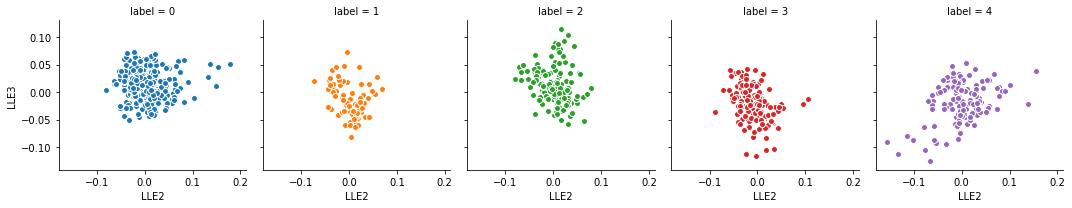

In [75]:
g = sns.FacetGrid(lle2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "LLE2", "LLE3", edgecolor="w"))

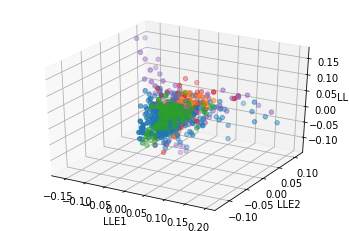

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

lle3_df3 = lle3_df2.groupby("label")

for name, group in lle3_df3:
    ax.scatter(group["LLE2"], group["LLE3"], group["LLE4"], marker="o", label=name)

ax.set_xlabel('LLE1')
ax.set_ylabel('LLE2')
ax.set_zlabel('LLE3')

plt.show()

## MLLE

Modified Local Linear Embedding

In [77]:
from sklearn.manifold import LocallyLinearEmbedding

In [78]:
mlle2 = LocallyLinearEmbedding(n_components=2, method = 'modified')
mlle3 = LocallyLinearEmbedding(n_components=3, method = 'modified')

In [79]:
mlle_dim2 = mlle2.fit_transform(cluster_data)
mlle_dim3 = mlle3.fit_transform(cluster_data)

In [80]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [81]:
mlle2_df = pd.DataFrame(data = mlle_dim2, index = indices, columns = ['MLLE1', 'MLLE2'])
mlle3_df = pd.DataFrame(data = mlle_dim3, index = indices, columns = ['MLLE1', 'MLLE2', 'MLLE3'])

In [82]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [83]:
mlle2_df2 = pd.concat([mlle2_df, cluster_labels_pd], axis=1, sort=False)
mlle3_df2 = pd.concat([mlle3_df, cluster_labels_pd], axis=1, sort=False)

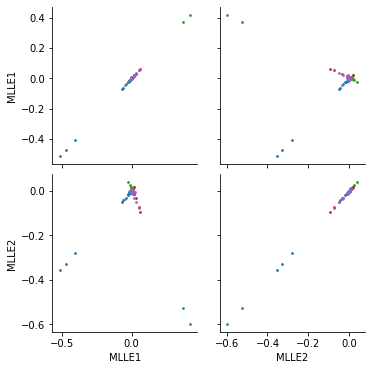

In [84]:
g = sns.PairGrid(mlle2_df2, hue = 'label')
g.map(plt.scatter, s=3);

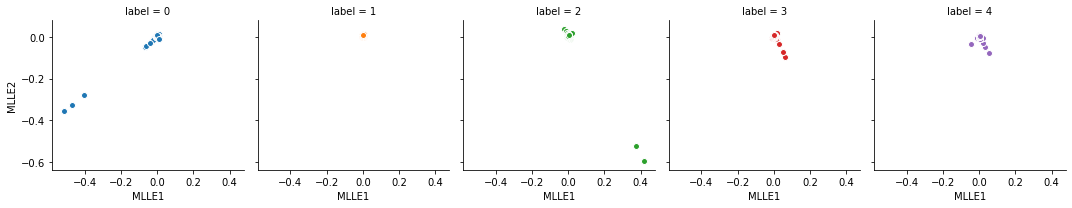

In [85]:
g = sns.FacetGrid(mlle2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "MLLE1", "MLLE2", edgecolor="w"))

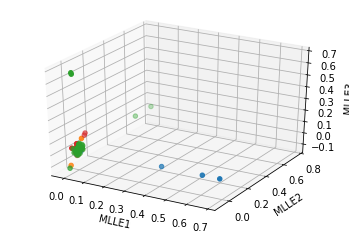

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mlle3_df3 = mlle3_df2.groupby("label")

for name, group in mlle3_df3:
    ax.scatter(group["MLLE1"], group["MLLE2"], group["MLLE3"], marker="o", label=name)

ax.set_xlabel('MLLE1')
ax.set_ylabel('MLLE2')
ax.set_zlabel('MLLE3')

plt.show()

## HLLE

Hessian Eigenmapping (HLLE): Projects data to a lower dimension while preserving the local neighbourhood like LLE but uses the Hessian operator to better achieve this result and hence the name.

In [87]:
from sklearn.manifold import LocallyLinearEmbedding

In [88]:
hlle2 = LocallyLinearEmbedding(n_neighbors=6, n_components=2, method = 'hessian',  eigen_solver='dense')
hlle3 = LocallyLinearEmbedding(n_neighbors=10, n_components=3, method = 'hessian',  eigen_solver='dense')

In [89]:
hlle_dim2 = hlle2.fit_transform(cluster_data)

In [90]:
hlle_dim3 = hlle3.fit_transform(cluster_data)

In [91]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [92]:
hlle2_df = pd.DataFrame(data = hlle_dim2, index = indices, columns = ['HLLE1', 'HLLE2'])
hlle3_df = pd.DataFrame(data = hlle_dim3, index = indices, columns = ['HLLE1', 'HLLE2', 'HLLE3'])

In [93]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [94]:
hlle2_df2 = pd.concat([hlle2_df, cluster_labels_pd], axis=1, sort=False)
hlle3_df2 = pd.concat([hlle3_df, cluster_labels_pd], axis=1, sort=False)

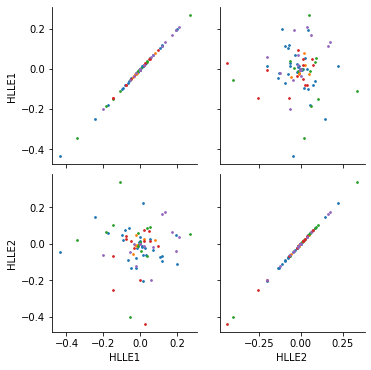

In [95]:
g = sns.PairGrid(hlle2_df2, hue = 'label')
g.map(plt.scatter, s=3);

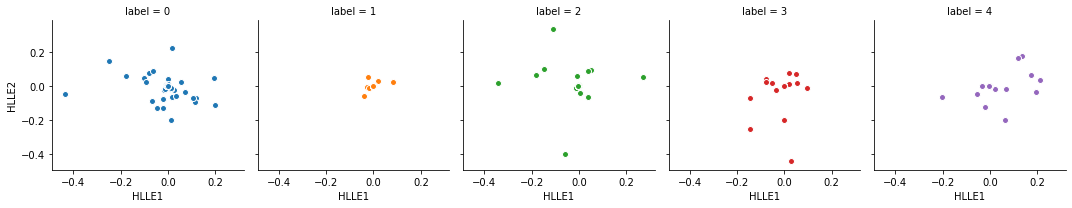

In [96]:
g = sns.FacetGrid(hlle2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "HLLE1", "HLLE2", edgecolor="w"))

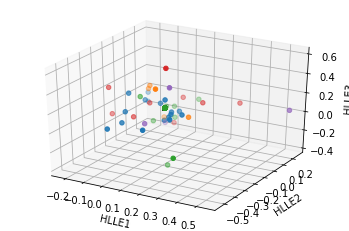

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

hlle3_df3 = hlle3_df2.groupby("label")

for name, group in hlle3_df3:
    ax.scatter(group["HLLE1"], group["HLLE2"], group["HLLE3"], marker="o", label=name)

ax.set_xlabel('HLLE1')
ax.set_ylabel('HLLE2')
ax.set_zlabel('HLLE3')

plt.show()

## LTSA

Local Tangent Space Alignment

In [98]:
from sklearn.manifold import LocallyLinearEmbedding

In [99]:
ltsa2 = LocallyLinearEmbedding(n_components=2, method = 'ltsa', eigen_solver='dense')
ltsa3 = LocallyLinearEmbedding(n_components=3, method = 'ltsa', eigen_solver='dense')

In [100]:
ltsa_dim2 = ltsa2.fit_transform(cluster_data)
ltsa_dim3 = ltsa3.fit_transform(cluster_data)

In [101]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [102]:
ltsa2_df = pd.DataFrame(data = ltsa_dim2, index = indices, columns = ['LTSA1', 'LTSA2'])
ltsa3_df = pd.DataFrame(data = ltsa_dim3, index = indices, columns = ['LTSA1', 'LTSA2', 'LTSA3'])

In [103]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [104]:
ltsa2_df2 = pd.concat([ltsa2_df, cluster_labels_pd], axis=1, sort=False)
ltsa3_df2 = pd.concat([ltsa3_df, cluster_labels_pd], axis=1, sort=False)

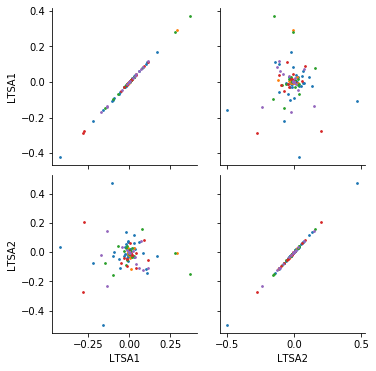

In [105]:
g = sns.PairGrid(ltsa2_df2, hue = 'label')
g.map(plt.scatter, s=3);

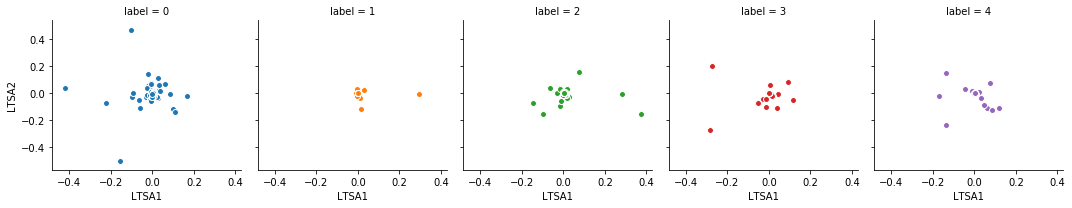

In [106]:
g = sns.FacetGrid(ltsa2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "LTSA1", "LTSA2", edgecolor="w"))

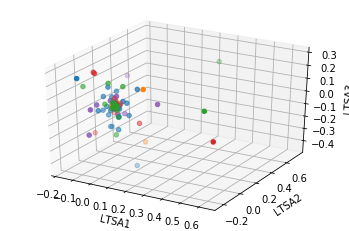

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ltsa3_df3 = ltsa3_df2.groupby("label")

for name, group in ltsa3_df3:
    ax.scatter(group["LTSA1"], group["LTSA2"], group["LTSA3"], marker="o", label=name)

ax.set_xlabel('LTSA1')
ax.set_ylabel('LTSA2')
ax.set_zlabel('LTSA3')

plt.show()

## SE

Spectral Embedding (Laplacian Eigenmaps): Uses spectral techniques to perform dimensionality reduction by mapping nearby inputs to nearby outputs. It preserves locality rather than local linearity

In [108]:
from sklearn.manifold import SpectralEmbedding

In [109]:
se2 = SpectralEmbedding(n_components=2)
se3 = SpectralEmbedding(n_components=3)

In [110]:
se_dim2 = se2.fit_transform(cluster_data)
se_dim3 = se3.fit_transform(cluster_data)

In [111]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [112]:
se2_df = pd.DataFrame(data = se_dim2, index = indices, columns = ['SE1', 'SE2'])
se3_df = pd.DataFrame(data = se_dim3, index = indices, columns = ['SE1', 'SE2', "SE3"])

In [113]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [114]:
se2_df2 = pd.concat([se2_df, cluster_labels_pd], axis=1, sort=False)
se3_df2 = pd.concat([se3_df, cluster_labels_pd], axis=1, sort=False)

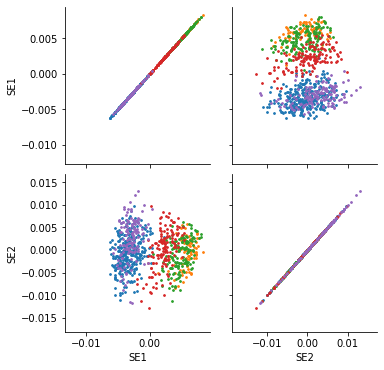

In [115]:
g = sns.PairGrid(se2_df2, hue = 'label')
g.map(plt.scatter, s=3);

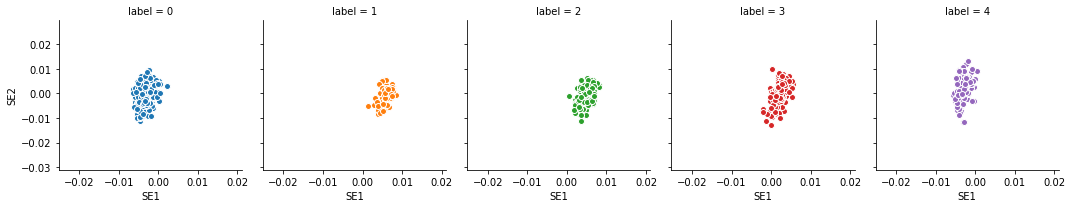

In [116]:
g = sns.FacetGrid(se2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "SE1", "SE2", edgecolor="w"))

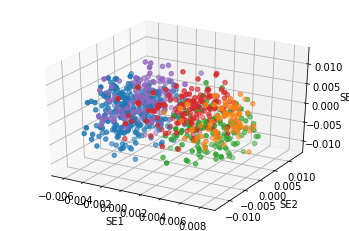

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

se3_df3 = se3_df2.groupby("label")

for name, group in se3_df3:
    ax.scatter(group["SE1"], group["SE2"], group["SE3"], marker="o", label=name)

ax.set_xlabel('SE1')
ax.set_ylabel('SE2')
ax.set_zlabel('SE3')
plt.savefig("Plot3")
plt.show()

## t-SNE

t-distributed Stochastic Neighbor Embedding (t-SNE): Computes the probability that pairs of data points in the high-dimensional space are related and then chooses a low-dimensional embedding which produce a similar distribution.

In [118]:
from sklearn.manifold import TSNE

In [119]:
tsne2 = TSNE(n_components=2)
tsne3 = TSNE(n_components=3)

In [120]:
tsne_dim2 = tsne2.fit_transform(cluster_data)
tsne_dim3 = tsne3.fit_transform(cluster_data)

In [121]:
indices = []
for i in range(cluster_data.shape[0]):
    indices.append("sample" + str(i))

In [122]:
tsne2_df = pd.DataFrame(data = tsne_dim2, index = indices, columns = ['TSNE1', 'TSNE2'])
tsne3_df = pd.DataFrame(data = tsne_dim3, index = indices, columns = ['TSNE1', 'TSNE2', "TSNE3"])

In [123]:
cluster_labels_pd = pd.DataFrame(data=cluster_labels, index=indices, columns=["label"])

In [124]:
tsne2_df2 = pd.concat([tsne2_df, cluster_labels_pd], axis=1, sort=False)
tsne3_df2 = pd.concat([tsne3_df, cluster_labels_pd], axis=1, sort=False)

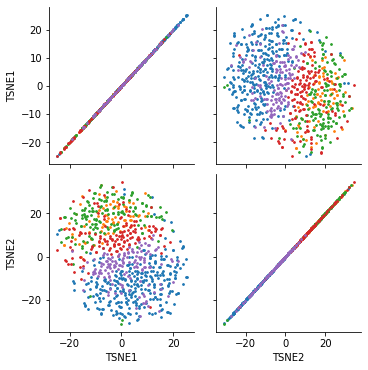

In [125]:
g = sns.PairGrid(tsne2_df2, hue = 'label')
g.map(plt.scatter, s=3);

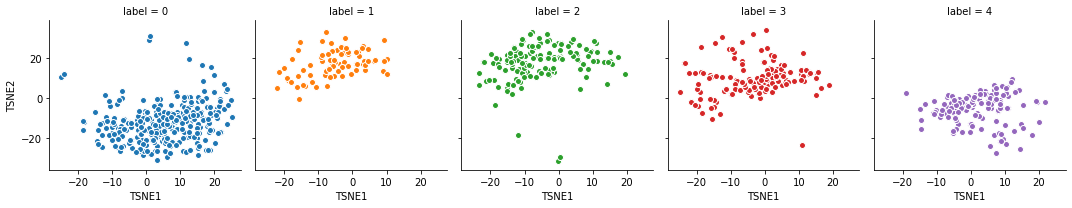

In [126]:
g = sns.FacetGrid(tsne2_df2, col="label", hue="label")
g = (g.map(plt.scatter, "TSNE1", "TSNE2", edgecolor="w"))

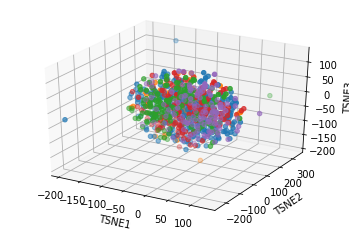

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tsne3_df3 = tsne3_df2.groupby("label")

for name, group in tsne3_df3:
    ax.scatter(group["TSNE1"], group["TSNE2"], group["TSNE3"], marker="o", label=name)

ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')

plt.show()